# Imports

In [1]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
import autograd.misc.optimizers as optims
import os
import importlib

# Function Definitions

In [2]:
# Weight initialisation
def init_random_params(scale, layer_sizes, rs=npr.RandomState(42)):
    return [(rs.randn(insize, outsize) * scale,   # weight matrix
             rs.randn(outsize) * scale)           # bias vector
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

# Activation function
def tanh(x):
    return (2 / (1.0 + np.exp(-2*x))) - 1
    #return np.log(1+np.exp(x))
    #return np.exp(x)

# Returns the NN output AFTER enforcing the boundary condition. This is the wavefunction (wf).
def psi(nnparams, inputs):
    origInput = inputs
    xTilde = (origInput - x0) / (x1 - x0)
    
    for W, b in nnparams:
        outputs = np.dot(inputs, W) + b
        inputs = tanh(outputs)    
        
    # Enforcing the boundary conditions
    return (1-xTilde)*psi0 + xTilde*psi1 + (1-np.exp(xTilde * (1 - xTilde))) * outputs


dpsi = elementwise_grad(psi, 1) # Function for returning first derivative of wf (not used explicitly)
ddpsi = elementwise_grad(dpsi, 1) # Second derivative of wf. 

In [3]:
PRC1 = 20 # Probability regularisation co-efficient for degree 1 (and -1)
PRC2 = PRC1/(2*2) # Probability regularisation co-efficient for degree 2 (and -2)
PRC3 = PRC2/(2*3) # Probability regularisation co-efficient for degree 3 (and -3)
PRC4 = PRC3/(2*4) # Probability regularisation co-efficient for degree 4 (and -4)

def floatStr (Efloat) :
    Eint = int(np.floor(Efloat))
    if Efloat - Eint == 0 :
        return str(int(np.floor(Efloat)))
    else :
        Estr = str(Efloat)
        return str(int(np.floor(Efloat))) + "p" + Estr[Estr.find('.')+1:]

# Objective function
def objective(params, step):
    nnparams = params['nn']
    E = params['E']        
    
    wf = psi(nnparams,x)    # Wavefunction
    diffeq = -0.5 * ddpsi(nnparams, x)  - E*wf  # Schrodinger equation in functional form
    y2 = wf**2   # Probability density function
    
    # This is a numerical trapezoid integration
    prob = np.sum((y2[1:] + y2[0:-1]) / 2 * (x[1:] - x[0:-1]))
    

    return np.mean(diffeq**2) + (1-prob)**2 + (PRC1/prob + PRC1*prob) + \
        (PRC2/prob**2 + PRC2*prob**2) + (PRC3/prob**3 + PRC3*prob**3) + \
        (PRC4/prob**4 + PRC4*prob**4)


trunc = -1
iterList = []
diffeqList = []
diffeqDiffList = []
probList = []
lossList = []
EList = []
# Helper function for callback. Prints the following -
# 1. Iteration no.
# 2. MSE term
# 3. Probability integral
# 4. Loss
# 5. Eigen-energy 
def objectiveDebug (params, step) :
    nnparams = params['nn']
    E = params['E']   
    
    wf = psi(nnparams,x)    # Wavefunction
    diffeq = -0.5 * ddpsi(nnparams, x)  - E*wf  # Schrodinger equation in functional form
    y2 = wf**2   # Probability density function
    mean = np.mean(diffeq**2)  # MSE

    # This is a numerical trapezoid integration
    prob = np.sum((y2[1:] + y2[0:-1]) / 2 * (x[1:] - x[0:-1]))
    

    loss = mean + (1-prob)**2 + (PRC1/prob + PRC1*prob) + \
        (PRC2/prob**2 + PRC2*prob**2) + (PRC3/prob**3 + PRC3*prob**3) + \
        (PRC4/prob**4 + PRC4*prob**4)
    
    iterList.append (step)
    diffeqList.append (mean)
    probList.append (prob)
    lossList.append (loss)
    EList.append (float(params['E']))

    print ("Iteration " + str(step) + "\ndiffeq = " + str(mean) + " prob = " + str(prob))
    print ("loss = " + str(loss) + " E = " + str(params['E']))

# Callback function.
def callback(params, step, g):
    global trunc
    global diffeqList
    
    if step % 100 == 0:
        objectiveDebug (params, step)
        
        if step > 100 :
            if trunc == -1 and np.abs(diffeqDiffList[-1]) < 10**-2 and diffeqDiffList[-1] < 0 :
                trunc = int(step/100)
                print ("Set at index = " + str(trunc))        

# Initialisation

In [4]:
psi0 = 0 # Value of first boundary
psi1 = 0 # Value of second boundary
L = 4 # Length of the well
n = 6 # Energy level to be found
scale = 2 # Scale for initialisation
divs = 400 # divisions of the input space

x0 = 0  # Position of first boundary
x1 = L  # Position of second boundary

In [5]:
# Initialising the weights. They usually fall between 0 and 1 which causes the initial wavefunction
# to have a small probability integral over the range. Hence, I've put a scale factor of 2 that changes gives it
# a random (but sizeable) shape so that over the epochs, the probability integral converges to 1.
nnparams = init_random_params(scale/(x1-x0), layer_sizes=[1, 32, 32, 1])

# Intialise a guess eigenvalue to find a true eigenvalue near it
initE = 15.0
params = {'nn': nnparams, 'E': initE}

# Input space
x = np.linspace(x0, x1, divs)[:, None]

# Setting up the name for saving files
name = "n" + str(n)+ "L" + floatStr(L) + "E" + floatStr(float(params['E']))

# Optimization

In [6]:
optims = importlib.reload (optims)
params = optims.myAdam (grad(objective), params, callback=callback, step_size=0.001, diffeqList=diffeqList, probList=probList, diffeqDiffList = diffeqDiffList)

Iteration 100
diffeq = 37.630247102716524 prob = 0.7100672760180939
loss = 95.58201345983288 E = 14.904218273078222
---------------------------------
Iteration 200
diffeq = 36.969184270218264 prob = 0.7078455149525795
loss = 95.03684960363468 E = 14.808130518061741
diffeqDiff = -0.6610628324982599
---------------------------------
Iteration 300
diffeq = 36.48021904322334 prob = 0.7100594117616594
loss = 94.4323928668031 E = 14.71072276407435
diffeqDiff = -0.48896522699492095
---------------------------------
Iteration 400
diffeq = 35.86297547153652 prob = 0.7123759743923714
loss = 93.6959683321891 E = 14.612964796071504
diffeqDiff = -0.6172435716868208
---------------------------------
Iteration 500
diffeq = 34.908768731876066 prob = 0.7149205005429307
loss = 92.6127923704739 E = 14.515366201648526
diffeqDiff = -0.9542067396604565
---------------------------------
Iteration 600
diffeq = 32.940265982042504 prob = 0.7195354401762933
loss = 90.41547935508142 E = 14.41869879843384
diffeqDi

Iteration 4600
diffeq = 2.295704320765539 prob = 0.96870191608899
loss = 54.221414529919876 E = 11.856778486187904
diffeqDiff = -0.09990728643629643
---------------------------------
Iteration 4700
diffeq = 2.2032687538193603 prob = 0.970180832212598
loss = 54.12422994770769 E = 11.825559306413265
diffeqDiff = -0.09243556694617894
---------------------------------
Iteration 4800
diffeq = 2.1193449497781853 prob = 0.9719958431938314
loss = 54.03480605910223 E = 11.794796225968716
diffeqDiff = -0.08392380404117494
---------------------------------
Iteration 4900
diffeq = 2.043980988601194 prob = 0.9738261606532385
loss = 53.95425993883072 E = 11.7644556957818
diffeqDiff = -0.07536396117699118
---------------------------------
Iteration 5000
diffeq = 1.9758101914369781 prob = 0.9754503135122158
loss = 53.88179537528561 E = 11.734308291495664
diffeqDiff = -0.06817079716421603
---------------------------------
Iteration 5100
diffeq = 1.9119285410545166 prob = 0.9767392761982807
loss = 53.81

Iteration 9100
diffeq = 0.0963150207150632 prob = 0.996877458395657
loss = 51.97180566181692 E = 11.107418000854404
diffeqDiff = -0.013199059353712156
---------------------------------
Iteration 9200
diffeq = 0.08505333145716651 prob = 0.9970963794030732
loss = 51.96047749524613 E = 11.1085054152417
diffeqDiff = -0.011261689257896695
---------------------------------
Iteration 9300
diffeq = 0.07537001593239877 prob = 0.9973035485970476
loss = 51.950735737434464 E = 11.109047681847452
diffeqDiff = -0.009683315524767741
Reached 10**-2 at 9300
brk3Lim = 18600
lessTenThou = True
brkCount2 = 1
---------------------------------
Iteration 9400
diffeq = 0.0670149026005122 prob = 0.9976296764643473
loss = 51.94229741740564 E = 11.109194456178207
Set at index = 94
diffeqDiff = -0.008355113331886571
brkCount2 = 2
---------------------------------
Iteration 9500
diffeq = 0.05968417300516341 prob = 0.9977100148053487
loss = 51.934947840739625 E = 11.109070161323904
diffeqDiff = -0.00733072959534878

Iteration 12800
diffeq = 0.0100570808854751 prob = 1.0001798503565915
loss = 51.88505870329807 E = 11.103358965197385
diffeqDiff = -0.0001784166078699391
brkCount3 = 18
---------------------------------
Iteration 12900
diffeq = 0.010188502124230281 prob = 0.9985944600235894
loss = 51.885287745273324 E = 11.10335991673488
diffeqDiff = 0.00013142123875518018
---------------------------------
Iteration 13000
diffeq = 0.009710525728017718 prob = 0.999676526681035
loss = 51.88471577658138 E = 11.103335142403507
diffeqDiff = -0.0004779763962125625
brkCount3 = 19
---------------------------------
Iteration 13100
diffeq = 0.009544035011318222 prob = 0.9989097277500409
loss = 51.88460373161251 E = 11.10331921556768
diffeqDiff = -0.00016649071669949667
brkCount3 = 20
---------------------------------
Iteration 13200
diffeq = 0.009487573754800199 prob = 1.0009378827860242
loss = 51.884531661050445 E = 11.10332099146618
diffeqDiff = -5.6461256518022807e-05
Reached 10**-4 at 13200
endLim = 26400
br

# Plots

In [7]:
replot = 0
if replot == 1 :
    params['E'] = initE
    n = 5
    L = 4
    name = "n" + str(n)+ "L" + floatStr(L) + "E" + floatStr(float(params['E']))

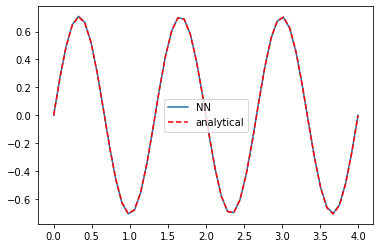

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
x = np.linspace(x0, x1)[:, None]
y = psi(params['nn'], x)

plt.plot(x, y, label='NN')  # Plotting the NN output
plt.plot(x, np.sqrt(2/L) * np.sin(n*np.pi * (x-x0)/L), 'r--', label='analytical')  # Plotting the actual wavefuncion
plt.legend()
plt.savefig (name + "_plot.png")

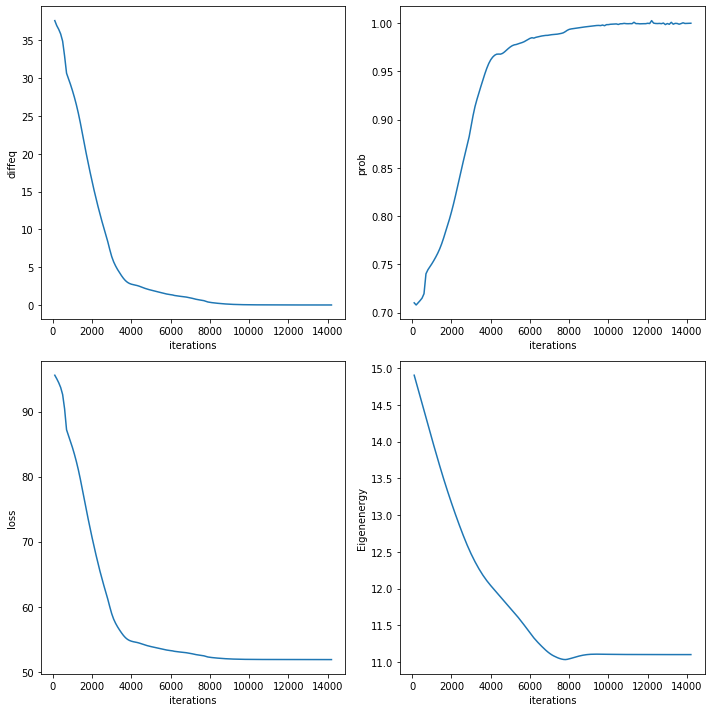

In [9]:
fig = plt.figure (figsize=(10,10))
plt.clf ()

plt.subplot (2 , 2 , 1)
plt.plot (iterList, diffeqList)
plt.xlabel ('iterations')
plt.ylabel ('diffeq')

plt.subplot (2, 2, 2)
plt.plot (iterList, probList)
plt.xlabel ('iterations')
plt.ylabel ('prob')

plt.subplot (2, 2, 3)
plt.plot (iterList, lossList)
plt.xlabel ('iterations')
plt.ylabel ('loss')

plt.subplot (2, 2, 4)
plt.plot (iterList, EList)
plt.ylabel ('Eigenenergy')
plt.xlabel ('iterations')
plt.tight_layout()

plt.savefig (name + "_diagAll.png")

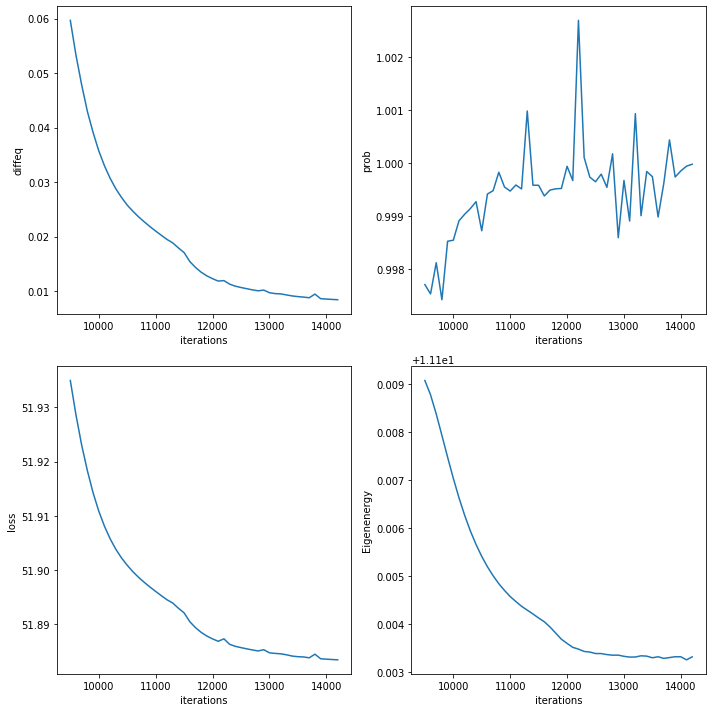

In [10]:
if trunc != -1 :
    fig = plt.figure (figsize=(10,10))

    plt.subplot (2 , 2 , 1)
    plt.plot (iterList[trunc:], diffeqList[trunc:])
    plt.xlabel ('iterations')
    plt.ylabel ('diffeq')

    plt.subplot (2, 2, 2)
    plt.plot (iterList[trunc:], probList[trunc:])
    plt.xlabel ('iterations')
    plt.ylabel ('prob')

    plt.subplot (2, 2, 3)
    plt.plot (iterList[trunc:], lossList[trunc:])
    plt.xlabel ('iterations')
    plt.ylabel ('loss')

    plt.subplot (2, 2, 4)
    plt.plot (iterList[trunc:], EList[trunc:])
    plt.ylabel ('Eigenenergy')
    plt.xlabel ('iterations')
    plt.tight_layout()

    plt.savefig (name + "_diagTrunc" + str(trunc) + ".png")

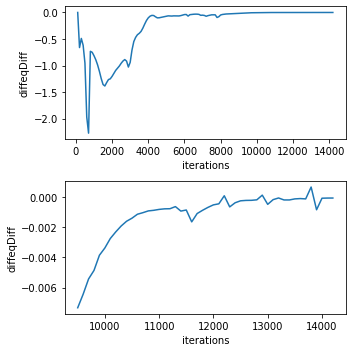

In [11]:
fig = plt.figure (figsize=(5,5))
plt.clf ()

if trunc != -1 :
    plt.subplot (2 , 1 , 1)
    plt.plot (iterList, diffeqDiffList)
    plt.xlabel ('iterations')
    plt.ylabel ('diffeqDiff')

    plt.subplot (2 , 1 , 2)
    plt.plot (iterList[trunc:], diffeqDiffList[trunc:])
    plt.xlabel ('iterations')
    plt.ylabel ('diffeqDiff')
else :
    plt.plot (iterList, diffeqDiffList)
    #plt.yticks ([min(diffeqDiffList), -10**-4, 10**-4, max(diffeqDiffList)])
    plt.xlabel ('iterations')
    plt.ylabel ('diffeqDiff')

plt.tight_layout()
plt.savefig (name + "_diffeqDiff.png")

# Write to file

In [12]:
outfile = open(name + "_info.txt" , "w")

fstr = "diffeq = " + str(round(diffeqList[-1],8)) + \
"\nprob = " + str(round(probList[-1],8)) + \
"\nloss = " + str(round(lossList[-1],8)) + \
"\neigE = " + str(round(EList[-1],8)) + \
"\ndiffeqDiff = " + str(round(diffeqDiffList[-1],8))

    
outfile.write (fstr)
outfile.close ()